# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [1]:
push!(LOAD_PATH, ".")
using PreprocTools
using HDF5, PyPlot, Statistics

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/PreprocTools.ji for PreprocTools [top-level]
└ @ Base loading.jl:1190


La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [33]:
abrestring="/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"

In [34]:
abrestring

"/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"

In [35]:
data=abrecacho(abrestring)

Dict{String,Any} with 3 entries:
  "intervalo" => [15700.0, 16700.0]
  "lfp"       => Float32[-4125.0 0.0 … 0.0 0.0; -12.085 24.1699 … 32.2266 10.07…
  "freq"      => 17.8555

In [36]:
lfp=data["lfp"]
intervalo=data["intervalo"]
freq=data["freq"];
data=0

0

Para archivos monstruosamente grandes, o dividimos automaticamente en cachos todo, o escogemos intervalos interesantes y de ahi trabajamos los cachos.

In [37]:
(rengs, cols, nmax)=size(lfp)

(64, 64, 17857)

In [38]:
tiempototalms=round(nmax/freq; digits=1) 
println("Tienes ", nmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 17857 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  1000.1ms.


In [39]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.3833171091238627

In [40]:
exc=lfp[3,27,:];

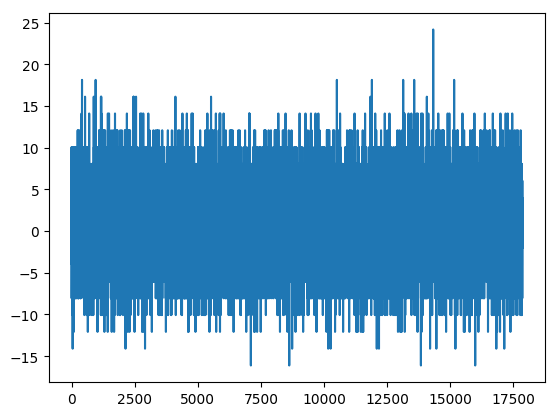

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff5569d3048>

In [41]:
plot(exc)

In [42]:
# De donde a donde quieres recortar
renglonmin=16
renglonmax=50
colmin=32
colmax=64

64

In [43]:
sublfp=lfp[renglonmin:renglonmax, colmin:colmax,:];

In [44]:
round(Sys.free_memory()/Sys.total_memory(),digits=4)

0.3828

In [47]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
inib=1 # inicio busqueda en ms
finb=900 # fin busqueda en ms

PruebaRespuesta=BuscaCanalRespActPot(lfp, inib, finb, freq,-100,-800,12,30)
Saturados=BuscaSaturados(lfp, inib, finb, freq, 801 )
satstd=BuscaSaturadosStd(lfp, inib, finb, freq, 10, 30)
satrd=BuscaRuidosos(lfp, inib, finb, freq, 200, 20)
numerosaturados=size(Saturados)[1]
numsatstd=size(satstd, 1)
numsatrd=size(satrd, 1)
numbom=size(PruebaRespuesta, 1)
println("Encontramos ", numerosaturados, " canales malos por promedio alto.")
println("Encontramos ", numsatstd, " canales malos por mucha desviacion alto.")
println("Encontramos ", numsatrd, " canales malos por ruidi.")
println("Encontramos ", numbom, " canales probablemente con actividad.")


Estoy buscando del cuadro 18 al , 16070
Encontramos 19 canales malos por promedio alto.
Encontramos 78 canales malos por mucha desviacion alto.
Encontramos 65 canales malos por ruidi.
Encontramos 166 canales probablemente con actividad.


### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [48]:
(alto, ancho, nmax)=size(lfp)
DesviacionPorCanal=zeros(alto,ancho)
ventastd=zeros(alto,ancho)
for j=1:alto
    for k=1:ancho
        ChorizoExemplo=vec(lfp[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
        aux=desviacionventanas(ChorizoExemplo, 100, freq)
        ventastd[j,k]=mean(aux)
    end
end

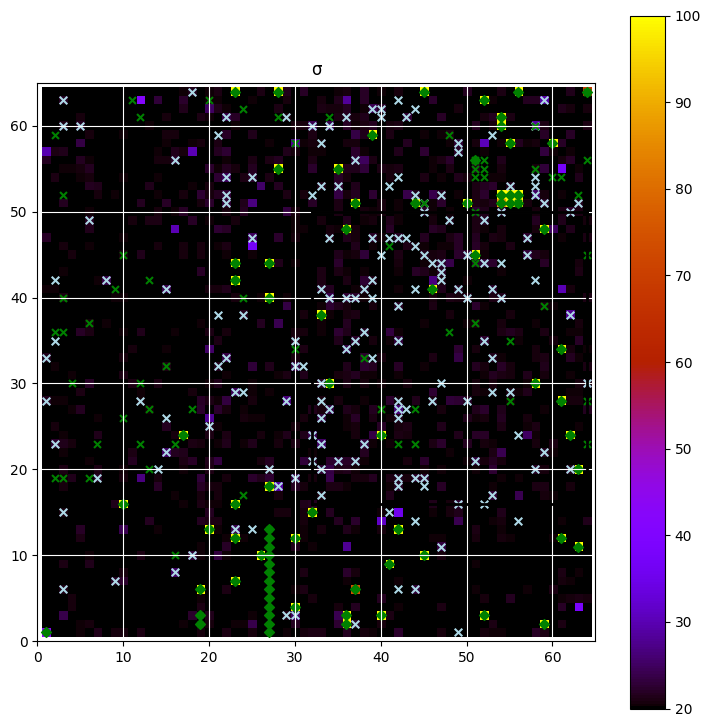

In [56]:
figure(figsize=(9,9))
xlim(0,ancho+1)
ylim(0, alto+1)
title("σ")
limsup=20
liminf=100
imagen=imshow(ventastd, origin="lower", interpolation="nearest",cmap="gnuplot", 
                      vmin=liminf,vmax=limsup, extent=[0.5,ancho+0.5,0.5,alto+0.5])
cb=colorbar()

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


plot([colmin, colmin], [renglonmin,renglonmax], lw=2, c="black")
plot([colmin, colmax], [renglonmax,renglonmax], lw=2, c="black")
plot([colmax, colmax], [renglonmax,renglonmin], lw=2, c="black")
plot([colmax, colmin], [renglonmin,renglonmin], lw=2, c="black")



x2=[]
y2=[]
for j in 1:numerosaturados
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


x3=[]
y3=[]
for j in 1:numsatstd
  append!(x3,satstd[j,2])
   append!(y3,satstd[j,1])
end


x4=[]
y4=[]
for j in 1:numsatrd
  append!(x4,satrd[j,2])
   append!(y4,satrd[j,1])
end



scatter(x,y, marker="x",c="lightblue", s=30)
scatter(x2,y2, marker="o",c="green", s=25)
scatter(x3,y3, marker="D",c="green", s=25)
scatter(x4,y4, marker="x",c="green", s=25)
grid(color="white")

In [57]:
egtrazo=lfp[28,42,:];

In [58]:
std(egtrazo)

20.462036f0

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

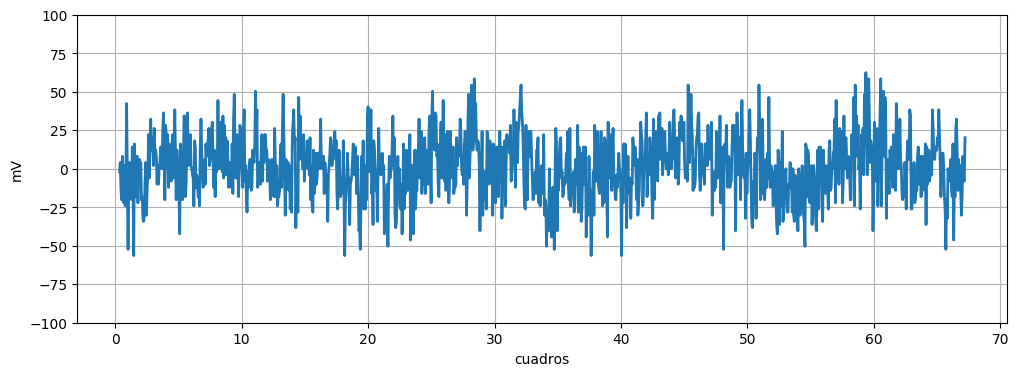

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff556317c88>

In [62]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-100,100)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=6
hasta=1200
#intervalo=1:cacho
intervalo=desde:hasta
it=intervalo./freq
grid()
plot(it,egtrazo[intervalo], lw=2)

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [ ]:
dirname(stringgeneral), basename(stringgeneral)

In [ ]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
indicadorespecifico="_subdatos.h5"
outname=string(dirgen,palabritaespecial, basegen, indicadorespecifico)
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPRecortado" => Subdatos,
     "cols" => [colmin, colmax],
      "rengs" => [renglonmin, renglonmax],
     "freq" =>freq,
     "Canalesrespuesta" => PruebaRespuesta,
     "CanalesSaturados" => Saturados)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)


In [ ]:
typeof(Subdatos)

In [ ]:
Subdatos=convert.(Float32, Subdatos)